# 混合ガウス分布

p(x)=Σk:1_K[π_k*(x|μ_k,Σ_k)

潜在変数zを導入
zはK次元でK個要素のうちどれか一つだけ1である(one-hot-vector)
zはデータxがどのガウス分布から生成されたかを表し、下のような分布になります

p(z_k=1)=π_k
p(x|z_k=1)=π_k*N(x|μ_k,Σ_k)

p(x)=Σz[p(x,z)]=Σz[p(z)p(x|z)]=ΣK[π_k*N(x|μ_k,Σ_k)]

潜在変数zの事後確率・・・負担率 
γ(z_nk)=p(z_k=1|x_n)= N(x_n|μ_k,Σk) * π_k / Σj:1_K[N(x_n|μ_j,Σj) * π_j]

# 対数尤度関数
log[p(X|π,μ,Σ)] = Σn:1_N[log(Σk:1_K(N(x_n|μk,Σk)))]

これを偏微分して、

μk = Σn:1_N[γ(z_nk)x_n] / Nk

Σk = Σn:1_N[γ(z_nk)(x_n - μ_k)(x_n - μ_k)^T

πk = Nk / N

※ Nk = Σn:1_N γ(z_nk)

# 混合ガウス分布のためのEMアルゴリズム

1. 平均μ_k, 分散Σ_k, 混合係数π_k を初期化して、対数尤度の初期値を計算

2. Eステップ：現在のパラメータ値を使って、負担率を計算

3. Mステップ：現在の負担率を使って、パラメタ μ_k, Σ_k, π_k を計算

4. 対数尤度の変化を見て収束性を確認し、収束基準を満たしていなければ、Eステップに戻る

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from pylab import *

In [2]:
# 混合ガウス分布のEMアルゴリズム

K = 2 # 混合ガウス分布の数（固定）

def scale(X):
    """
    データ行列X(サンプル数、特徴数)のフィールド(カラム列)ごとに標準化
    """
    
    col = X.shape[1]
    
    # フィールドごとに平均値と標準偏差を計算
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    
    for i in range(col):
        X[:, i] = (X[:, i] - mu[i]) / sigma[i]
        
    return X

In [3]:
def gaussian(x, mean, cov):
    """
    多変量ガウス関数
    """
    sample_n = x.shape[0]
    coef1 = 1 / ((2 * np.pi) ** (sample_n / 2.0))
    coef2 = 1 / (np.linalg.det(cov) ** 0.5)
    diff = x - mean
    content = - 0.5 * np.dot( np.dot(diff.T, np.linalg.inv(cov)), diff) # 横ベクトルx縦ベクトル
    
    return coef1 * coef2 * np.exp(content)

In [4]:
def log_likelihood(X, mean, cov, pi):
    """
    対数尤度関数
    """
    log_likelihood = 0.0
    
    for n in range(len(X)):
        likelihood = 0.0
        for k in range(K):
            likelihood += pi[k] * gaussian(X[n], mean[k], cov[k])
        log_likelihood += np.log(likelihood)
        
    return log_likelihood

# メインプログラム

mean: [[0.98930202 0.35813296]
 [0.15957167 0.61337802]]
cov: [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
pi: [0.8426688  0.17841954]
gauss_dist: 0.104017052698698
log_likelihood: -888.1164949033757
turn:0, logLike:-888.1164949033757
turn:1, logLike:-544.2256648978578
turn:2, logLike:-543.8972852326829
turn:3, logLike:-543.489739315092
turn:4, logLike:-542.9375995518086
turn:5, logLike:-542.1243055858671
turn:6, logLike:-540.8044445546901
turn:7, logLike:-538.3829050572571
turn:8, logLike:-533.1545023206081
turn:9, logLike:-519.2689827550805
turn:10, logLike:-476.36260751193595
turn:11, logLike:-396.9713764959515
turn:12, logLike:-385.4866367978305
turn:13, logLike:-385.46211527381547


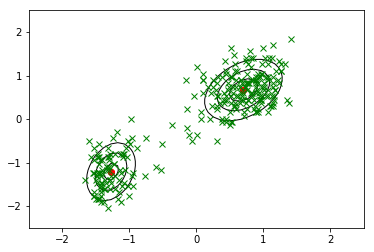

In [8]:
# トレーニングデータのロード
data = np.genfromtxt("./data/faithful.txt")
X = data[:, 0:2]
X = scale(X) # データの標準化
N = len(X) # サンプルサイズ
#print(X[:5])
#print(N)

# 平均μ_k, 分散Σ_k, 混合係数π_k を初期化して、対数尤度の初期値を計算
mean = np.random.rand(K, X.shape[1]) # 0~1
cov = []
for k in range(K):
    cov.append(np.eye(X.shape[1], X.shape[1]))
cov = np.array(cov)
pi = np.random.rand(K)
print("mean:", mean)
print("cov:", cov)
print("pi:", pi)
print("gauss_dist:", gaussian(X[0], mean[0], cov[0]))

# 負担率の空配列を用意
gamma = np.zeros((N, K))

# 対数尤度の初期値を計算
logLike = log_likelihood(X, mean, cov, pi)
print("log_likelihood:", logLike)



turn = 0
while True:
    print("turn:{0}, logLike:{1}".format(turn, logLike))
    
    # Eステップ：現在のパラメタを使って、負担率を計算
    for n in range(N):
        # 分母はkによらないので、最初に1回だけ計算
        denominator = 0.0
        for j in range(K):
            denominator += pi[j] * gaussian(X[n], mean[j], cov[j])
        # 各kについて負担率を計算
        for k in range(K):
            gamma[n][k] = pi[k] * gaussian(X[n], mean[k], cov[k]) / denominator
            
    
    # Mステップ：現在の負担率を使って、パラメタを再計算
    for k in range(K):
        
        # N_kを計算する
        Nk = 0.0
        for n in range(N):
            Nk += gamma[n][k]
        
            
        # 平均を再計算
        mean[k] = np.array([0.0, 0.0])
        for n in range(N):
            #print("X[n]:\n", X[n])
            mean[k] += gamma[n][k] * X[n]
        mean[k] /= Nk
        
        # 共分散を再計算
        cov[k] = np.array([[0.0, 0.0], [0.0, 0.0]])
        for n in range(N):
            diff = X[n] - mean[k]
            # 縦ベクトルx横ベクトル
            cov[k] += gamma[n][k] * np.matrix(diff).reshape(2, 1) * np.matrix(diff).reshape(1,2)
        cov[k] /=Nk
        
        # 混合係数を再計算
        pi[k] = Nk / N
        
    # 収束判定
    new_logLike = log_likelihood(X, mean, cov, pi)
    diff_logLike = new_logLike - logLike
    if diff_logLike < 0.01:
        break
    logLike = new_logLike
    turn += 1
    
# ガウス分布の平均を描画
for k in range(K):
    plt.scatter(mean[k, 0], mean[k, 1], c='r', marker='o')
    
# 等高線を描画
xlist = np.linspace(-2.5, 2.5, 50)
ylist = np.linspace(-2.5, 2.5, 50)
x, y = np.meshgrid(xlist, ylist)
#pos = np.dstack((xlist, ylist))
for k in range(K):
    z = bivariate_normal(x, y, 
                         np.sqrt(cov[k, 0, 0]), 
                         np.sqrt(cov[k, 1, 1]),
                        mean[k, 0],
                        mean[k, 1],
                        cov[k, 0, 1])
    #z = stats.multivariate_normal(mean[k], cov[k]).pdf(pos)
    
    cs = contour(x, y, z, 3, colors='k', linewidths=1)
    
# トレーニングデータを描画
plt.plot(X[:, 0], X[:, 1], 'gx')
xlim(-2.5, 2.5)
ylim(-2.5, 2.5)
plt.show()